# Demo Regression

In this notebook, we will look showcase how to implement a JAX trainer for research purposes. We will use the documentation from the [uvadlc notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html) and adapt this to the libraries I would like to use:
* serket
* optax

In [1]:
import pytorch_lightning
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
# Standard libraries
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

# JAX/Flax
# If you run this code on Colab, remember to install flax and optax
# !pip install --quiet --upgrade flax optax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
# from flax.training import train_state, checkpoints
import optax

# PyTorch for data loading
import torch
import torch.utils.data as data

# Logging with Tensorboard or Weights and Biases
# If you run this code on Colab, remember to install pytorch_lightning
# !pip install --quiet --upgrade pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_60714/3835948096.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
import equinox as eqx


## Data

In [4]:
def target_function(x):
    return np.sin(x * 3.0)

class RegressionDataset(data.Dataset):

    def __init__(self, num_points, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.x = rng.uniform(low=-2.0, high=2.0, size=num_points)
        self.y = target_function(self.x)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [5]:
train_set = RegressionDataset(num_points=1000, seed=42)
val_set = RegressionDataset(num_points=200, seed=43)
test_set = RegressionDataset(num_points=500, seed=44)

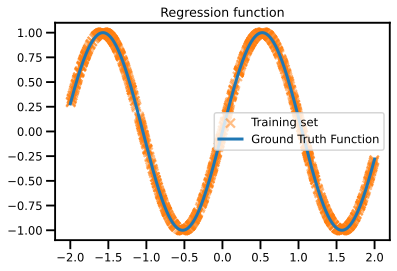

In [6]:

x = np.linspace(-2, 2, 1000)
plt.scatter(train_set.x, train_set.y, color='C1', marker='x', alpha=0.5, label='Training set')
plt.plot(x, target_function(x), linewidth=3.0, label='Ground Truth Function')
plt.legend()
plt.title('Regression function')
plt.show()

## DataModule

In [7]:
from mylib._src.datamodules.base import NumpyLoader, numpy_collate
import pytorch_lightning as pl

class RegressionDataModule(pl.LightningDataModule):
    def __init__(
            self, num_train: int=1000, num_valid: int=200, num_test: int=500, seed=42,
            num_workers: int=0, batch_size: int=32):
        super().__init__()
        self.num_train = num_train
        self.num_valid = num_valid
        self.num_test = num_test
        self.seed = seed
        self.num_workers = num_workers
        self.batch_size = batch_size

    def setup(self, stage: str=None) -> None:
        self.train_set = RegressionDataset(num_points=self.num_train, seed=42)
        self.val_set = RegressionDataset(num_points=self.num_valid, seed=43)
        self.test_set = RegressionDataset(num_points=self.num_test, seed=44)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.val_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )
    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.test_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )



In [8]:
dm = RegressionDataModule(num_train=1_000, num_valid=200, num_test=500,
                          batch_size=128)
dm.setup()

In [9]:
for ibatch in tqdm(dm.train_dataloader()):
    break

print(ibatch[0].shape, ibatch[1].shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(128, 1) (128, 1)


## Trainer State

In [10]:
from mylib._src.trainers.trainstate import TrainState

In [24]:
import equinox as eqx
from mylib._src.nets.nerfs.siren import SirenNet
import jax.random as jrandom


model = SirenNet(
    in_dim=1, out_dim=1, hidden_dim=128, n_hidden=3,
    key=jrandom.PRNGKey(123)
)

# class Swish(eqx.Module):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#
#     def __call__(self, x, *, key=None):
#         return jax.nn.swish(x)
#
# model = eqx.nn.Sequential(
#     [eqx.nn.Linear(in_features=1, out_features=128, key=jrandom.PRNGKey(123)),
#      Swish(),
#      eqx.nn.Linear(in_features=128, out_features=128, key=jrandom.PRNGKey(123)),
#      Swish(),
#      eqx.nn.Linear(in_features=128, out_features=1, key=jrandom.PRNGKey(123))
#      ]
# )

# model = eqx.nn.MLP(
#     in_size=1, out_size=1, width_size=128, depth=2,
#     key=jrandom.PRNGKey(123)
# )

print(model)

SirenNet(
  layers=[
    Siren(weight=f32[128,1], bias=f32[128], w0=30, activation=Sine(w0=30)),
    Siren(weight=f32[128,128], bias=f32[128], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[128,128], bias=f32[128], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[1,128], bias=f32[1], w0=1.0, activation=Identity())
  ],
  num_layers=4,
  hidden_dim=128,
  final_scale=1.0,
  final_activation=Identity()
)


In [25]:
learning_rate = 4e-3
warmup_steps = 10
num_epochs = 100
num_steps_per_epoch = len(dm.train_dataloader())
eta = 0.01
start_lr = 0.0

optimizer = optax.adamw(learning_rate=learning_rate)
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=start_lr,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=int(num_epochs * num_steps_per_epoch),
    end_value=eta * learning_rate
)
clip = optax.clip_by_global_norm(2.0)
optimizer = optax.chain(
    clip,
    optax.adamw(lr_scheduler)
)
# optimizer.init(model)

## Trainer Module

In [26]:
from mylib._src.trainers.base import TrainerModule

class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 input_init,
                 **kwargs):
        super().__init__(model=model, optimizer=optimizer, input_init=input_init, **kwargs)

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss

        def train_step(model, batch, optim, opt_state):
            loss, grads = mse_loss(model, batch)
            updates, opt_state = optim.update(grads, opt_state)
            model = eqx.apply_updates(model, updates)
            metrics = {"loss": loss}
            return loss, metrics, model, optim, opt_state


        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            return {"loss": loss}

        return train_step, eval_step

    def init_optimizer(self, num_epochs: int, num_steps_per_epoch):

        learning_rate = 4e-3

        opt_class = optax.adam

        lr_scheduler = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=learning_rate,
            warmup_steps=10,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value = 0.01 * learning_rate
        )

        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            opt_class(lr_scheduler)
        )
        return optimizer

    def init_logger(self, logger_params=None):

        self.logger = WandbLogger(
            mode="disabled",
            save_dir=self.log_dir,
            entity="ige",
            project="jax4eo"
        )


In [27]:

trainer = RegressorTrainer(model, optimizer, input_init=ibatch[0], seed=123, debug=False, enable_progress_bar=False)


/Users/eman/miniconda3/envs/jax_eo_py39/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [28]:

# trainer.load_model("./checkpoint.ckpt")

In [34]:
%%time


metrics = trainer.train_model(dm, 500)

Epochs: 500 | Loss: 1.436e-03: 100%|██████████| 500/500 [00:10<00:00, 47.05it/s]

CPU times: user 11 s, sys: 862 ms, total: 11.8 s
Wall time: 10.6 s


In [35]:
metrics

{'train/loss': 0.0014356370083987713, 'epoch_time': 0.021901845932006836}

In [36]:
trainer.save_model("checkpoint.ckpt")

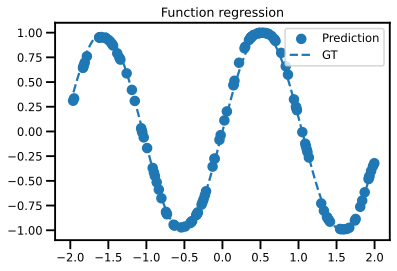

In [37]:
x = np.linspace(-2, 2, 1000)[:,None]
y_pred = jax.vmap(trainer.model)(ibatch[0])
plt.scatter(ibatch[0], y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

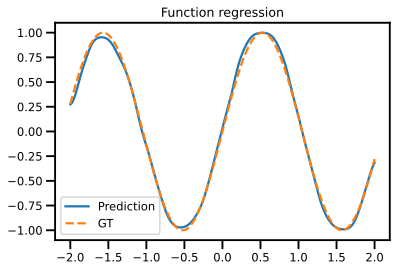

In [38]:
x = np.linspace(-2, 2, 1000)[:,None]
y_pred = jax.vmap(trainer.model)(x)
plt.plot(x, y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

In [39]:
# !wget https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc

In [52]:
import xarray as xr
import pandas as pd

ds = xr.open_dataset(
    "NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc", decode_times=True)#.assign_coords(time=lambda ds: pd.to_datetime(ds.time))
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
Data variables:
    sst      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [41]:
from matplotlib import cm
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=-1.1, vmax=1.1)
cmap = cm.RdBu_r

m = cm.ScalarMappable(norm=norm, cmap=cmap)

(365, 201, 201)

In [72]:

class SineCosCycles:
    def __init__(self):
        pass

    def transform(self, x):
        data = x["time"]
        data = data.dt.day_of_year
        data = np.concatenate(
            [
                np.sin(data["doy"] / 360 * 2 * np.pi),
                np.cos(data["doy"] / 360 * 2 * np.pi)
            ]
        )
        x["time"] = data
        return x
class SSTDataset(data.Dataset):

    def __init__(self, time_slice, variable, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        ds = xr.open_dataset(
            "NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
        df = ds.isel(time=time_slice).to_dataframe().reset_index()
        df["doy"] = df["time"].dt.day_of_year
        df["sin_time"] = np.sin(df[["doy"]] /360 * 2 * np.pi)
        df["cos_time"] = np.cos(df[["doy"]] /360 * 2 * np.pi)
        self.x = {}
        self.x["spatial"] = df[["lat", "lon"]].values
        self.x["temporal"] = df[["lat", "lon"]].values
        self.y = df[[variable]].values

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [73]:
sst_ds = SSTDataset(slice(60, 90), "sst", 123)
sst_ds[0]


(array([[ 3.30000000e+01, -6.50000000e+01,  1.74524064e-02,
          9.99847695e-01]]),
 array([[22.49443047]]))

In [49]:
class SSTDataModule(pl.LightningDataModule):
    def __init__(
            self, time_slice, variable, seed=42,
            num_workers: int=0, batch_size: int=1028):
        super().__init__()
        self.time_slice = time_slice
        self.variable = variable
        self.seed = seed
        self.num_workers = num_workers
        self.batch_size = batch_size

    def setup(self, stage: str=None) -> None:
        dataset = SSTDataset(time_slice=self.time_slice, variable=self.variable, seed=42)
        num_pts = len(dataset)
        num_train = np.ceil(0.8 * num_pts)
        num_valid = np.ceil(0.2 * num_pts)
        self.train_set, self.valid_set = torch.utils.data.random_split(dataset, lengths=[num_train, num_valid])

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.val_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )
    # def test_dataloader(self):
    #     return data.DataLoader(
    #         dataset=self.test_set,
    #         batch_size=self.batch_size,
    #         collate_fn=numpy_collate,
    #         num_workers=self.num_workers,
    #         shuffle=False,
    #     )

In [54]:
dm = SSTDataModule(slice("2013-01-01", "2013-02-01"), "sst")
dm.setup()

TypeError: cannot perform __truediv__ with this index type: DatetimeArray